## Decomposition Refreshed

In [5]:
using Revise
using Random
using Printf
using StaticArrays
using DataStructures
using Flux
using FileIO
using BSON
using JLD2
using ProgressMeter
using POMDPs
using POMDPModelTools
using POMDPSimulators
using POMDPPolicies
using BeliefUpdaters
using DeepRL
using DeepQLearning
using LocalApproximationValueIteration
using DiscreteValueIteration
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using MDPModelChecking
using PedCar
using AutomotiveSensors
using Reel

loaded


┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/LocalApproximationValueIteration/Dvh7I.ji for LocalApproximationValueIteration [a40420fb-f401-52da-a663-f502e5b95060]
└ @ Base loading.jl:1184
┌ Warning: Package LocalApproximationValueIteration does not have Random in its dependencies:
│ - If you have LocalApproximationValueIteration checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LocalApproximationValueIteration
└ Loading Random into LocalApproximationValueIteration from project dependency, future warnings for LocalApproximationValueIteration are suppressed.
┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/PedCar/NmDDZ.ji for PedCar [90cf7f26-d5c7-593d-a0e1-4a8367407571]
└ @ Base loading.jl:1184
┌ Warning: Package PedCar does not have AutomotivePOMDPs in its depen

In [ ]:
includet("../src/masking.jl")
includet("../src/util.jl")
includet("../src/masked_dqn.jl")
includet("../src/qmdp_approximation.jl")
includet("../src/render_helpers.jl")
includet("RNNFiltering/RNNFiltering.jl")
using Main.RNNFiltering

In [3]:
rng = MersenneTwister(1)
cam = FitToContentCamera(0.);

## Environment

In [19]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
#                    sensor = PerfectSensor(),
                    sensor = GaussianSensor(false_positive_rate=0.0, false_negative_rate = 0.0,
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                   obs_dist = ObstacleDistribution(mdp.env, 
                                                   upper_obs_pres_prob=0., 
                                                   left_obs_pres_prob=1.0, 
                                                   right_obs_pres_prob=1.0),
                   max_cars=2, 
                   max_peds=2, 
                   car_birth=0.1, 
                   ped_birth=0.1, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);

# instantiate sub problems
## CAR POMDP FOR TRACKING 1 CAR
car_pomdp = deepcopy(pomdp)
car_pomdp.max_peds = 0
car_pomdp.max_cars = 1
## PED POMDP FOR TRACKING 1 PEDESTRIAN
ped_pomdp = deepcopy(pomdp)
ped_pomdp.max_peds = 1
ped_pomdp.max_cars = 0
## PEDCAR POMDP FOR THE POLICY (Model checking + DQN)
pedcar_pomdp = deepcopy(pomdp)
pedcar_pomdp.max_peds = 1
pedcar_pomdp.max_cars = 1
pedcar_pomdp.max_obstacles = 0

0

## Load RNN Belief Updater and Policy

In [5]:
n_models = 5
car_models = Vector{Chain}(undef, n_models)
ped_models = Vector{Chain}(undef, n_models)
for i=1:n_models
    car_models[i] = BSON.load("training_scripts/RNNFiltering/model_car_$i.bson")[:model] 
    Flux.loadparams!(car_models[i], BSON.load("training_scripts/RNNFiltering/weights_car_$i.bson")[:weights])
    ped_models[i] = BSON.load("training_scripts/RNNFiltering/model_ped_$i.bson")[:model]
    Flux.loadparams!(ped_models[i], BSON.load("training_scripts/RNNFiltering/weights_ped_$i.bson")[:weights])
end
pres_threshold = 0.3;

In [6]:
threshold = 0.99
@load "pc_util_processed.jld2" qmat util pol
safe_policy = ValueIterationPolicy(mdp, qmat, util, pol);
mask = SafetyMask(mdp, safe_policy, threshold);

In [7]:
problem_file="training_scripts/drqn-log/log8/problem.bson"
weights_file="training_scripts/drqn-log/log8/weights.bson"
env_ = POMDPEnvironment(pedcar_pomdp)
dqn_policy = DeepQLearning.restore(env_, problem_file=problem_file, weights_file=weights_file)
masked_policy = MaskedNNPolicy(pedcar_pomdp, dqn_policy, mask);

2018-10-26 18:04:03.975250: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


## Simulation

In [20]:
function POMDPModelTools.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
    sp, o, r = generate_sor(pomdp, s, a, rng)
    return sp, o, r, deepcopy(pomdp.models)
end

function POMDPModelTools.action_info(policy::DecMaskedPolicy, b::MultipleAgentsBelief)
    global pomdp
    pedcar_beliefs = create_pedcar_beliefs(pomdp, b) #XXX is using global variable pomdp
    a, ai = action_info(policy, pedcar_beliefs)
    safe_acts, probs, probs_dict, safe_acts_dict = ai
    return a, (safe_acts, probs, probs_dict, safe_acts_dict, pedcar_beliefs, deepcopy(pomdp.models))
end

In [21]:
dec_pol = DecMaskedPolicy(masked_policy, mask, pedcar_pomdp, (x,y) -> min.(x,y));

In [24]:
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());

s0 = initialstate(pomdp, rng)
a0 = UrbanAction(0.)
empty_b = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}())
o0 = generate_o(pomdp,s0, a0, s0, rng)
b0 = update(up, empty_b, a0, o0)
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, pomdp, dec_pol, up, b0, s0);

  5.193430 seconds (22.81 M allocations: 1.578 GiB, 19.36% gc time)


In [25]:
animate_history(hist, pomdp,
#                 obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
#                 belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                ainfo_overlays = ai -> [[InterpolationOverlay(mdp, ai[end], obs_to_scene(pedcar_pomdp, ai[end-1][i].predictions[j])) for j=1:n_models for i in keys(ai[end-1])]...,
                                         TextOverlay(text = ["Available Actions: $([a.acc for a in ai[1]])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true),
                                         [ TextOverlay(text = ["$vehid: $([a.acc for a in acts])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,-15-1.5*i), incameraframe=true) for (i,(vehid, acts)) in enumerate(ai[4])]...],
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 12.0))

Frames{MIME{Symbol("image/png")}}("/tmp/tmpE8m86I", 0x0000000000000049, 10.0, nothing)

## Evaluation

In [14]:
function evaluation_loop(pomdp::UrbanPOMDP, policy::Policy, up::MultipleAgentsTracker; n_ep::Int64 = 1000, max_steps::Int64 = 500, rng::AbstractRNG = Base.GLOBAL_RNG)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    violations = zeros(n_ep)
    @showprogress for ep=1:n_ep
        delete!.(Ref(up.single_trackers), k for k in keys(up.single_trackers))
        s0 = initialstate(pomdp, rng)
        a0 = UrbanAction(0.)
        empty_b = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}())
        o0 = generate_o(pomdp,s0, a0, s0, rng)
        b0 = update(up, empty_b, a0, o0)
        hr = HistoryRecorder(max_steps=100, rng=rng)
        hist = simulate(hr, pomdp, dec_pol, up, b0, s0);
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
        violations[ep] = is_crash(hist.state_hist[end])#sum(hist.reward_hist .<= -1.) #+ Int(n_steps(hist) >= max_steps)
    end
    return rewards, steps, violations
end

evaluation_loop (generic function with 3 methods)

In [15]:
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, dec_pol, up, n_ep=100, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:04

381.106772 seconds (1.22 G allocations: 88.007 GiB, 19.13% gc time)
Summary for 100 episodes: 
Average reward: 0.021 
Average # of steps: 77.360 
Average # of violations: 1.000 


Progress: 100%|█████████████████████████████████████████| Time: 0:06:21


## Error analysis

In [16]:
include("decomposition.jl")

create_pedcar_states (generic function with 1 method)

In [17]:
@showprogress for ep=1:10000
    global hist
    ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                        AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
    up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());

    s0 = initialstate(pomdp, rng)
    a0 = UrbanAction(0.)
    empty_b = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}())
    o0 = generate_o(pomdp,s0, a0, s0, rng)
    b0 = update(up, empty_b, a0, o0)
    hr = HistoryRecorder(max_steps=400, rng=rng)
    hist = simulate(hr, pomdp, dec_pol, up, b0, s0);
    if sum(hist.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Progress:   1%|                                         |  ETA: 16:07:32

Crash


Progress: 100%|█████████████████████████████████████████| Time: 0:11:11


In [18]:
animate_history(hist, pomdp,
#                 obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
#                 belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                action_overlays = a-> [TextOverlay(text = ["Acc: $(a.acc)"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,8.), incameraframe=true)],
                ainfo_overlays = ai -> [[InterpolationOverlay(mdp, ai[end], obs_to_scene(pedcar_pomdp, ai[end-1][i].predictions[j])) for j=1:n_models for i in keys(ai[end-1])]...,
                                         TextOverlay(text = ["Available Actions: $([a.acc for a in ai[1]])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true),
                                         [ TextOverlay(text = ["$vehid: $([a for a in acts])"], font_size=15,pos=VecE2(pomdp.env.params.x_min + 35,-8-1.9*i), incameraframe=true) for (i,(vehid, acts)) in enumerate(ai[3])]...],
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 12.0))

Frames{MIME{Symbol("image/png")}}("/tmp/tmpUjg30r", 0x0000000000000020, 10.0, nothing)

In [38]:
s = hist.state_hist[end - 4]
b = hist.ainfo_hist[end - 4][5]
bb = b[(2, 101,1)]

PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.215417, 1.0, 0.42, 0.000711217, 0.212845, -0.747486, 0.136436, -0.24282, 0.0276548, 1.00719, 0.095687], [0.0625, -0.215417, 1.0, 0.42, 0.0162518, 0.249588, -0.801901, 0.187845, -0.213451, -0.00989273, 0.973789, 0.103079], [0.0625, -0.215417, 1.0, 0.42, -0.0240651, 0.265608, -0.775372, 0.237054, -0.247915, -0.0196442, 0.975006, 0.114043], [0.0625, -0.215417, 1.0, 0.42, -0.0855629, 0.180073, -0.739143, 0.212066, -0.233062, 0.0114188, 1.02149, 0.106071], [0.0625, -0.215417, 1.0, 0.42, 0.0328453, 0.212662, -0.787419, 0.204028, -0.230685, 0.00203596, 0.998399, 0.0939353]], [0.0625, -0.215417, 1.0, 0.42, -0.105921, 0.251321, -0.762425, 0.238351, -0.219886, 0.015018, 1.0, 0.222582, 0.78125, 0.1875, -0.791667, -0.00333333])

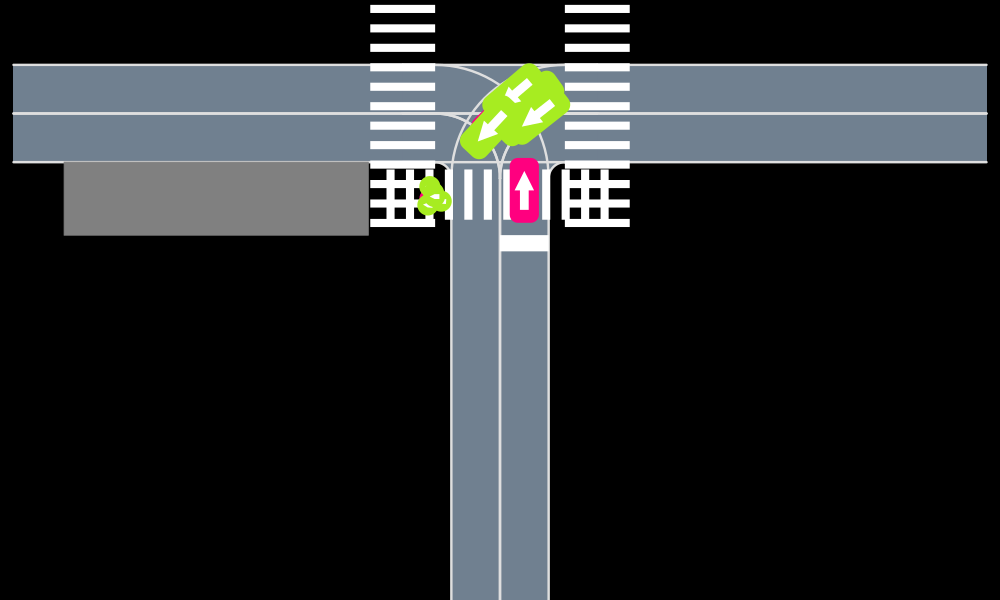

In [39]:
bel_overlay = PedCarBeliefOverlay(pedcar_pomdp, bb, MONOKAI["color2"])
AutoViz.render(s, pomdp.env, [bel_overlay], cam=FitToContentCamera(0.0))

In [35]:
safe_actions(pedcar_pomdp, mask, bb, 2, 101)

2-element Array{UrbanAction,1}:
 UrbanAction(-4.0)
 UrbanAction(-2.0)